In [120]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mapping import Mapping

%load_ext version_information
%version_information numpy, pandas, matplotlib
%version_information
fig_prefix = "../figures/2018-07-22-jw-weaselball-starting_location_"
data_prefix = "../data/2018-07-22-jw-weaselball-starting_location_"


The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


In [121]:
df = pd.read_csv('../data/2018-07-22-jw-weaselball_analysis_translation_matrix_out.csv')
print(df.shape)
df = df.apply(pd.to_numeric)
df.head()

(6300, 6300)


,0,1,2,3,4,5,6,7,8,9,...,6290,6291,6292,6293,6294,6295,6296,6297,6298,6299
0,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.071429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.066667,0.066667,0.066667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.066667,0.066667,0.066667,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.066667,0.066667,0.066667,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.066667,0.066667,0.066667,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
df_import_m = pd.read_csv('../data/2018-07-22-jw-weaselball_analysis_magnitude_vector_out.csv',  header=None);
magnitude_V = df_import_m.iloc[:,0]
magnitude_V = magnitude_V.apply(pd.to_numeric)
magnitude_V = magnitude_V.astype(float)
magnitude_V.head()

0    14.0
1    15.0
2    15.0
3    15.0
4    15.0
Name: 0, dtype: float64

In [123]:
NUMBER_OF_SQUARES = 100 #This should be a square number to create equal sized squares.
RESOLUTION_OF_S1 = 0.1 #This is used to discretize the yaw angle over 0 - 2*pi
START_X = 0
START_Y = 0
END_X = 9
END_Y = 9
END_YAW = 0
counter = 0

In [124]:
#The formula for mapping a 3D array to 1D is
#(z * xMax * yMax) + (y * xMax) + x;
#https://stackoverflow.com/questions/7367770/how-to-flatten-or-index-3d-array-in-1d-array
X_MAX = NUMBER_OF_SQUARES ** (1/2.0)
Y_MAX = NUMBER_OF_SQUARES ** (1/2.0)
YAW_MAX = (2 * np.pi) / RESOLUTION_OF_S1
mapping = Mapping(X_MAX, Y_MAX, YAW_MAX)#Fill in the logical areas that the system can reach (For now I am assuming it can go up/down 2 yaw states or the surronding (x,y) blocks)

In [125]:
#https://vknight.org/unpeudemath/code/2015/11/15/Visualising-markov-chains.html
#http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017

In [126]:
#Use Dijkstras to find shortest path to goal
#https://gist.github.com/kachayev/5990802
from collections import defaultdict
from heapq import *

def dijkstra(edges, f, t):
    #Create dict to represent graph
    g = defaultdict(list)
    #add edges to dictionary
    for l,r,c in edges:
        g[l].append((c,r))


    q, seen, mins = [(1,f,())], set(), {f: 0}
    while q:
        (cost,v1,path) = heappop(q)
        if v1 not in seen:
            seen.add(v1)
            path = (v1, path)
            if v1 == t: return (cost, path)

            for c, v2 in g.get(v1, ()):
                if v2 in seen: continue
                prev = mins.get(v2, None)
                next = -abs(cost * c)
                if prev is None or next < prev:
                    mins[v2] = next
                    heappush(q, (next, v2, path))

    return (float("inf"),)

In [131]:
#Convert translation matrix into edges for graph
edges = []
for col in df.columns:
    for idx in df.index:
        if(df.loc[idx,col] != 0):
            edges.append((int(col), int(idx), -df.loc[idx,col]))


In [128]:

#
#
print "({},{},x) -> ({},{},{}):".format(START_X, START_Y, END_X, END_Y, END_YAW)
x = range(int(np.pi/RESOLUTION_OF_S1))
x_results = []
for i in x:
    x_results.append(dijkstra(edges, mapping.map3Dto1D(START_X,START_Y,i), mapping.map3Dto1D(END_X,END_Y,END_YAW)))
print(x_results)
(m,i) = min((v,i) for i,v in enumerate(x_results))
print "State {} to state {}".format(mapping.map3Dto1D(START_X,START_Y,i), mapping.map3Dto1D(END_X,END_Y,END_YAW))
print "Min is x = {} with P = {}".format(i,m)



(0,0,x) -> (9,9,0):
[(-0.045454545454545456, (99, (0, ()))), (-0.045454545454545456, (99, (100, ()))), (-0.045454545454545456, (99, (200, ()))), (-0.0016835016835016834, (99, (189, (300, ())))), (-6.235191420376605e-05, (99, (188, (289, (400, ()))))), (-2.309330155695039e-06, (99, (188, (278, (389, (500, ())))))), (-8.553074650722366e-08, (99, (188, (277, (378, (489, (600, ()))))))), (-3.167805426193469e-09, (99, (188, (277, (367, (478, (589, (700, ())))))))), (-1.173261268960544e-10, (99, (188, (277, (366, (477, (588, (699, (800, ()))))))))), (-4.345412107261274e-12, (99, (188, (277, (366, (466, (577, (688, (799, (900, ())))))))))), (-1.6094118915782497e-13, (99, (188, (277, (366, (455, (556, (667, (778, (889, (1000, ()))))))))))), (-6.705882881576038e-15, (99, (108, (217, (326, (435, (546, (656, (767, (878, (989, (1100, ())))))))))))), (-5.960784783623146e-15, (99, (208, (317, (426, (535, (645, (756, (867, (978, (1089, (1200, ())))))))))))), (-2.2076980680085728e-16, (99, (198, (308,

In [ ]:
#Take best path and make it into 

In [135]:
xvalues = np.array(range(int(X_MAX)))
yvalues = np.array(range(int(Y_MAX)))

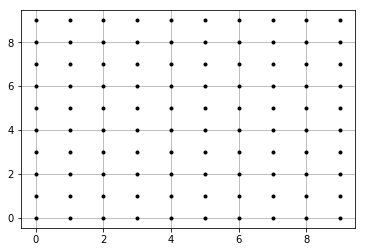

In [142]:
xx, yy = np.meshgrid(xvalues, yvalues)
plt.grid()
plt.plot(xx, yy, marker='.', color='k', linestyle=' ')